##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Core API を使用した数字認識のための多層パーセプトロン

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/guide/core/mlp_core"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">     TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/guide/core/mlp_core.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colabで実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/guide/core/mlp_core.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHubでソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/guide/core/mlp_core.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

このノートブックでは、[TensorFlow Core 低レベル API](https://www.tensorflow.org/guide/core) を使用して、[多層パーセプトロン](https://developers.google.com/machine-learning/crash-course/introduction-to-neural-networks/anatomy)と [MNIST データセット](http://yann.lecun.com/exdb/mnist)を使用し、手書きの数字を分類するためのエンドツーエンドの機械学習ワークフローを構築します。TensorFlow Core とその意図するユースケースの詳細については、[Core API の概要](https://www.tensorflow.org/guide/core)を参照してください。

## 多層パーセプトロン（MLP）の概要

多層パーセプトロン（MLP）は、[マルチクラス分類](https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/video-lecture)の問題に使用される一種のフィードフォワードニューラルネットワークです。MLP を構築する前に、パーセプトロン、レイヤー、活性化関数の概念を理解することが重要です。

多層パーセプトロンは、パーセプトロンと呼ばれる単位で構成されています。パーセプトロンの方程式は次のとおりです。

ここでは、

これらのパーセプトロンが積み重ねられると、高密度レイヤーと呼ばれる構造が形成され、それらを接続してニューラルネットワークを構築できます。高密度レイヤーの方程式はパーセプトロンの方程式に似ていますが、代わりに重み行列とバイアスベクトルを使用します。

- $Z$: パーセプトロン出力
- $\mathrm{X}$: 特徴行列
- $\vec{w}$: 重みベクトル
- $b$: バイアス

これらのパーセプトロンが積み重ねられると、高密度レイヤーと呼ばれる構造が形成され、それらを接続してニューラルネットワークを構築できます。高密度レイヤーの方程式はパーセプトロンの方程式に似ていますが、代わりに重み行列とバイアスベクトルを使用します。

$$Y = \mathrm{W}⋅\mathrm{X} + \vec{b}$$

ここでは、それそれ以下を意味します。

- $Z$: 高密度レイヤー出力
- $\mathrm{X}$: 特徴行列
- $\mathrm{W}$: 重み行列
- $\vec{b}$: バイアスベクトル

MLP では、複数の高密度レイヤーが接続され、1 つのレイヤーの出力は次のレイヤーの入力に完全に接続されます。高密度レイヤーの出力に非線形活性化関数を追加すると、MLP 分類器が複雑な決定境界を学習し、トレーニングに使用されていないデータに対して適切に一般化するのに役立ちます。

## セットアップ

まず、TensorFlow、[pandas](https://pandas.pydata.org)、[Matplotlib](https://matplotlib.org) および [seaborn](https://seaborn.pydata.org) をインポートします。

In [2]:
# Use seaborn for countplot.
!pip install -q seaborn

In [3]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import tempfile
import os
# Preset Matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
print(tf.__version__)
# Set random seed for reproducible results 
tf.random.set_seed(22)

2024-01-11 19:05:24.353219: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 19:05:24.353268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 19:05:24.354822: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


## データを読み込む

このチュートリアルでは [MNIST データセット](http://yann.lecun.com/exdb/mnist)を使用し、手書きの数字を分類できる MLP モデルを構築する方法を示します。データセットは [TensorFlow データセット](https://www.tensorflow.org/datasets/catalog/mnist)から入手できます。

MNIST データセットをトレーニングセット、検証セット、およびテストセットに分割します。検証セットを使用して、トレーニング中にモデルの一般化可能性を評価し、テストセットを使用してモデルの最終的なバイアスのないパフォーマンスを推定します。


In [5]:
train_data, val_data, test_data = tfds.load("mnist", 
                                            split=['train[10000:]', 'train[0:10000]', 'test'],
                                            batch_size=128, as_supervised=True)

MNIST データセットは、手書きの数字とそれに対応する真のラベルで構成されています。以下のいくつかの例を視覚化します。

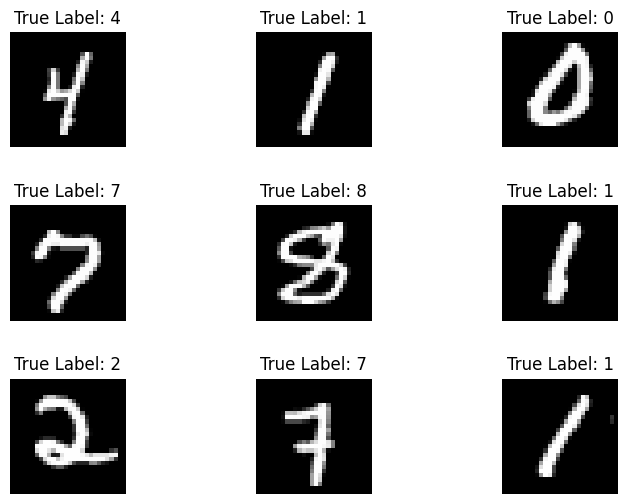

In [6]:
x_viz, y_viz = tfds.load("mnist", split=['train[:1500]'], batch_size=-1, as_supervised=True)[0]
x_viz = tf.squeeze(x_viz, axis=3)

for i in range(9):
    plt.subplot(3,3,1+i)
    plt.axis('off')
    plt.imshow(x_viz[i], cmap='gray')
    plt.title(f"True Label: {y_viz[i]}")
    plt.subplots_adjust(hspace=.5)


また、トレーニングデータの数字の分布を調べて、各クラスがデータセットで適切に表現されていることを確認します。


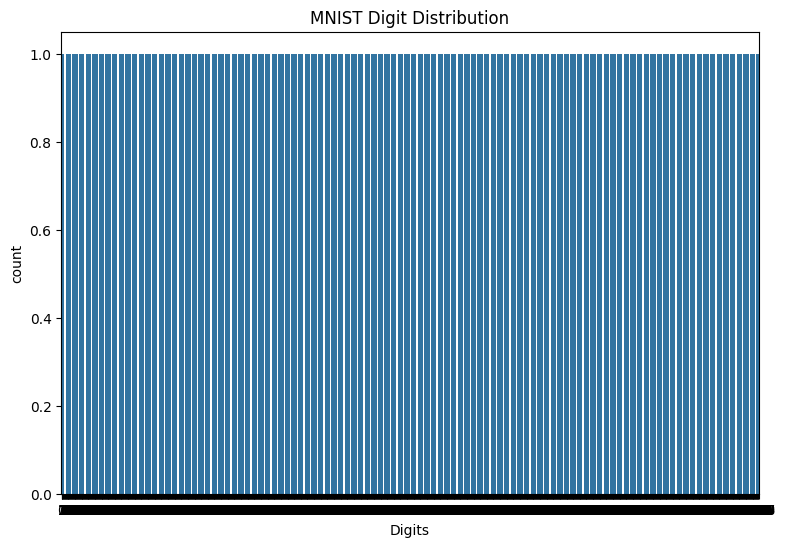

In [7]:
sns.countplot(y_viz.numpy());
plt.xlabel('Digits')
plt.title("MNIST Digit Distribution");

## データを処理する

まず、画像を平坦化し、特徴行列を 2 次元に再形成します。次に、[0,255] のピクセル値が [0,1] の範囲に収まるようにデータを再スケーリングします。この手順により、入力ピクセルが同様の分布を持つようになり、トレーニングの収束に役立ちます。

In [8]:
def preprocess(x, y):
  # Reshaping the data
  x = tf.reshape(x, shape=[-1, 784])
  # Rescaling the data
  x = x/255
  return x, y

train_data, val_data = train_data.map(preprocess), val_data.map(preprocess)

## MLP を構築する

まず、[ReLU](https://developers.google.com/machine-learning/glossary#ReLU) と [ソフトマックス](https://developers.google.com/machine-learning/glossary#softmax)活性化関数を視覚化します。両方の関数は、それぞれ `tf.nn.relu` と `tf.nn.softmax` で利用できます。 ReLU は、正の場合は入力を出力し、それ以外の場合は 0 を出力する非線形活性化関数です。

$$\text{ReLU}(X) = max(0, X)$$

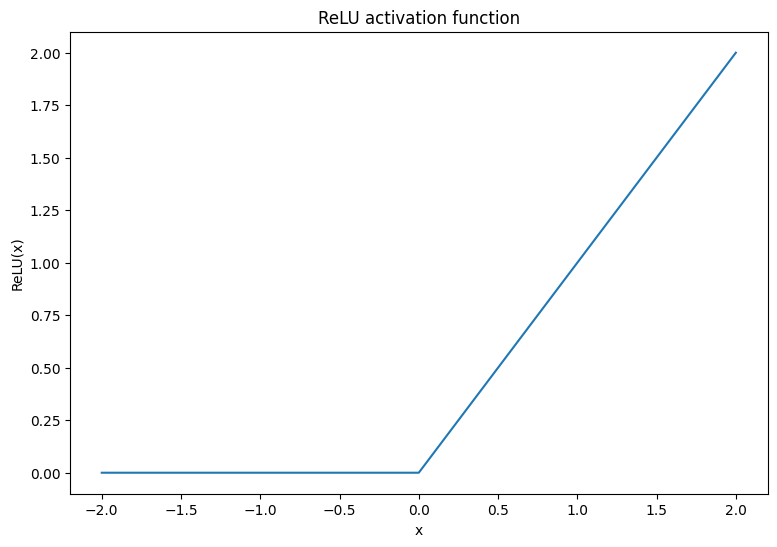

In [9]:
x = tf.linspace(-2, 2, 201)
x = tf.cast(x, tf.float32)
plt.plot(x, tf.nn.relu(x));
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.title('ReLU activation function');

ソフトマックス活性化関数は、$m$ 実数を $m$ 結果/クラスの確率分布に変換する正規化された指数関数です。これは、ニューラルネットワークの出力からクラスの確率を予測するのに役立ちます。

$$\text{Softmax}(X) = \frac{e^{X}}{\sum_{i=1}^{m}e^{X_i}}$$

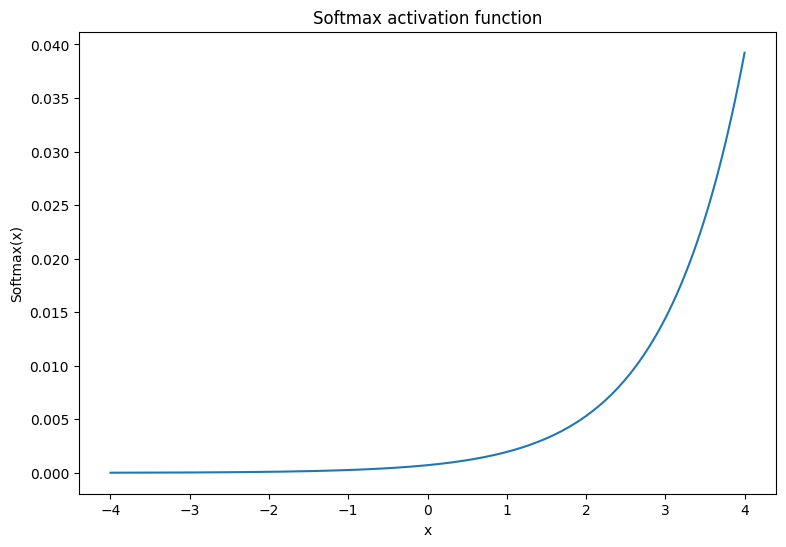

In [10]:
x = tf.linspace(-4, 4, 201)
x = tf.cast(x, tf.float32)
plt.plot(x, tf.nn.softmax(x, axis=0));
plt.xlabel('x')
plt.ylabel('Softmax(x)')
plt.title('Softmax activation function');

### 高密度レイヤー

高密度レイヤーのクラスを作成します。定義により、1 つのレイヤーの出力は、MLP の次のレイヤーの入力に完全に接続されます。したがって、高密度レイヤーの入力次元は、前のレイヤーの出力次元に基づいて推測でき、初期化時に事前に指定する必要はありません。活性化出力が大きくなりすぎたり小さくなりすぎたりしないように、重みも適切に初期化する必要があります。最も一般的な重みの初期化方法の 1 つは、重み行列の各要素が次の方法でサンプリングされる Xavier スキームです。

$$W_{ij} \sim \text{Uniform}(-\frac{\sqrt{6}}{\sqrt{n + m}},\frac{\sqrt{6}}{\sqrt{n + m}})$$

バイアスベクトルはゼロに初期化できます。

In [11]:
def xavier_init(shape):
  # Computes the xavier initialization values for a weight matrix
  in_dim, out_dim = shape
  xavier_lim = tf.sqrt(6.)/tf.sqrt(tf.cast(in_dim + out_dim, tf.float32))
  weight_vals = tf.random.uniform(shape=(in_dim, out_dim), 
                                  minval=-xavier_lim, maxval=xavier_lim, seed=22)
  return weight_vals

また、Xavier の初期化メソッドは `tf.keras.initializers.GlorotUniform` で実装することもできます。

In [12]:
class DenseLayer(tf.Module):

  def __init__(self, out_dim, weight_init=xavier_init, activation=tf.identity):
    # Initialize the dimensions and activation functions
    self.out_dim = out_dim
    self.weight_init = weight_init
    self.activation = activation
    self.built = False

  def __call__(self, x):
    if not self.built:
      # Infer the input dimension based on first call
      self.in_dim = x.shape[1]
      # Initialize the weights and biases using Xavier scheme
      self.w = tf.Variable(xavier_init(shape=(self.in_dim, self.out_dim)))
      self.b = tf.Variable(tf.zeros(shape=(self.out_dim,)))
      self.built = True
    # Compute the forward pass
    z = tf.add(tf.matmul(x, self.w), self.b)
    return self.activation(z)

次に、レイヤーを順次実行する MLP モデルのクラスを作成します。モデル変数は、次元の推定により、高密度レイヤー呼び出しの最初のシーケンスの後にのみ使用できることに注意してください。

In [13]:
class MLP(tf.Module):

  def __init__(self, layers):
    self.layers = layers
   
  @tf.function
  def __call__(self, x, preds=False): 
    # Execute the model's layers sequentially
    for layer in self.layers:
      x = layer(x)
    return x

次のアーキテクチャで MLP モデルを初期化します。

- フォワードパス: ReLU(784×700)×ReLU(700×500)×Softmax(500×10)

ソフトマックス活性化関数は、MLP によって適用される必要はありません。これは、損失関数と予測関数で別々に計算されます。

In [14]:
hidden_layer_1_size = 700
hidden_layer_2_size = 500
output_size = 10

mlp_model = MLP([
    DenseLayer(out_dim=hidden_layer_1_size, activation=tf.nn.relu),
    DenseLayer(out_dim=hidden_layer_2_size, activation=tf.nn.relu),
    DenseLayer(out_dim=output_size)])

### 損失関数を定義する

交差エントロピー損失関数は、モデルの確率予測に従ってデータの負の対数尤度を測定するため、マルチクラス分類問題に最適です。真のクラスに割り当てられる確率が高いほど、損失は低くなります。交差エントロピー損失の式は次のとおりです。

$$L = -\frac{1}{n}\sum_{i=1}^{n}\sum_{i=j}^{n} {y_j}^{[i]}⋅\log(\hat{{y_j}}^{[i]})$$

ここでは、それぞれ以下を意味します。

- $\underset{n\times m}{\hat{y}}$: 予測されたクラス分布の行列
- $\underset{n\times m}{y}$: 真のクラスのワンホットエンコードされた行列

`tf.nn.sparse_softmax_cross_entropy_with_logits` 関数を使用して交差エントロピー損失を計算できます。この関数は、モデルの最後のレイヤーにソフトマックス活性化関数を適用する必要はなく、クラスラベルをホットエンコードする必要もありません。

In [15]:
def cross_entropy_loss(y_pred, y):
  # Compute cross entropy loss with a sparse operation
  sparse_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(sparse_ce)

トレーニング中に正しい分類の割合を計算する基本的な精度関数を記述します。ソフトマックス出力からクラス予測を生成するために、最大のクラス確率に対応するインデックスを返します。 

In [16]:
def accuracy(y_pred, y):
  # Compute accuracy after extracting class predictions
  class_preds = tf.argmax(tf.nn.softmax(y_pred), axis=1)
  is_equal = tf.equal(y, class_preds)
  return tf.reduce_mean(tf.cast(is_equal, tf.float32))

### モデルをトレーニングする

オプティマイザを使用すると、標準の勾配降下法に比べて収束が大幅に速くなる可能性があります。Adam オプティマイザは以下に実装されています。TensorFlow Core を使用したカスタムオプティマイザの設計について詳しくは、[オプティマイザ](https://www.tensorflow.org/guide/core/optimizers_core)ガイドを参照してください。

In [17]:
class Adam:

    def __init__(self, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7):
      # Initialize optimizer parameters and variable slots
      self.beta_1 = beta_1
      self.beta_2 = beta_2
      self.learning_rate = learning_rate
      self.ep = ep
      self.t = 1.
      self.v_dvar, self.s_dvar = [], []
      self.built = False
      
    def apply_gradients(self, grads, vars):
      # Initialize variables on the first call
      if not self.built:
        for var in vars:
          v = tf.Variable(tf.zeros(shape=var.shape))
          s = tf.Variable(tf.zeros(shape=var.shape))
          self.v_dvar.append(v)
          self.s_dvar.append(s)
        self.built = True
      # Update the model variables given their gradients
      for i, (d_var, var) in enumerate(zip(grads, vars)):
        self.v_dvar[i].assign(self.beta_1*self.v_dvar[i] + (1-self.beta_1)*d_var)
        self.s_dvar[i].assign(self.beta_2*self.s_dvar[i] + (1-self.beta_2)*tf.square(d_var))
        v_dvar_bc = self.v_dvar[i]/(1-(self.beta_1**self.t))
        s_dvar_bc = self.s_dvar[i]/(1-(self.beta_2**self.t))
        var.assign_sub(self.learning_rate*(v_dvar_bc/(tf.sqrt(s_dvar_bc) + self.ep)))
      self.t += 1.
      return 

次に、ミニバッチ勾配降下で MLP パラメータを更新するカスタムトレーニングループを作成します。トレーニングにミニバッチを使用すると、メモリ効率と収束のスピードが向上します。

In [18]:
def train_step(x_batch, y_batch, loss, acc, model, optimizer):
  # Update the model state given a batch of data
  with tf.GradientTape() as tape:
    y_pred = model(x_batch)
    batch_loss = loss(y_pred, y_batch)
  batch_acc = acc(y_pred, y_batch)
  grads = tape.gradient(batch_loss, model.variables)
  optimizer.apply_gradients(grads, model.variables)
  return batch_loss, batch_acc

def val_step(x_batch, y_batch, loss, acc, model):
  # Evaluate the model on given a batch of validation data
  y_pred = model(x_batch)
  batch_loss = loss(y_pred, y_batch)
  batch_acc = acc(y_pred, y_batch)
  return batch_loss, batch_acc

In [19]:
def train_model(mlp, train_data, val_data, loss, acc, optimizer, epochs):
  # Initialize data structures
  train_losses, train_accs = [], []
  val_losses, val_accs = [], []

  # Format training loop and begin training
  for epoch in range(epochs):
    batch_losses_train, batch_accs_train = [], []
    batch_losses_val, batch_accs_val = [], []

    # Iterate over the training data
    for x_batch, y_batch in train_data:
      # Compute gradients and update the model's parameters
      batch_loss, batch_acc = train_step(x_batch, y_batch, loss, acc, mlp, optimizer)
      # Keep track of batch-level training performance
      batch_losses_train.append(batch_loss)
      batch_accs_train.append(batch_acc)

    # Iterate over the validation data
    for x_batch, y_batch in val_data:
      batch_loss, batch_acc = val_step(x_batch, y_batch, loss, acc, mlp)
      batch_losses_val.append(batch_loss)
      batch_accs_val.append(batch_acc)

    # Keep track of epoch-level model performance
    train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
    val_loss, val_acc = tf.reduce_mean(batch_losses_val), tf.reduce_mean(batch_accs_val)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Epoch: {epoch}")
    print(f"Training loss: {train_loss:.3f}, Training accuracy: {train_acc:.3f}")
    print(f"Validation loss: {val_loss:.3f}, Validation accuracy: {val_acc:.3f}")
  return train_losses, train_accs, val_losses, val_accs

バッチ サイズ 128 で MLP モデルを 10 エポックトレーニングします。GPU や TPU などのハードウェアアクセラレータもトレーニング時間をスピードアップするのに役立ちます。 

In [20]:
train_losses, train_accs, val_losses, val_accs = train_model(mlp_model, train_data, val_data, 
                                                             loss=cross_entropy_loss, acc=accuracy,
                                                             optimizer=Adam(), epochs=10)

Epoch: 0
Training loss: 0.222, Training accuracy: 0.934
Validation loss: 0.121, Validation accuracy: 0.963


Epoch: 1
Training loss: 0.079, Training accuracy: 0.975
Validation loss: 0.099, Validation accuracy: 0.971


Epoch: 2
Training loss: 0.047, Training accuracy: 0.986
Validation loss: 0.088, Validation accuracy: 0.976


Epoch: 3
Training loss: 0.034, Training accuracy: 0.989
Validation loss: 0.095, Validation accuracy: 0.975


Epoch: 4
Training loss: 0.026, Training accuracy: 0.992
Validation loss: 0.110, Validation accuracy: 0.971


Epoch: 5
Training loss: 0.023, Training accuracy: 0.992
Validation loss: 0.103, Validation accuracy: 0.976


Epoch: 6
Training loss: 0.018, Training accuracy: 0.994
Validation loss: 0.096, Validation accuracy: 0.979


Epoch: 7
Training loss: 0.017, Training accuracy: 0.994
Validation loss: 0.110, Validation accuracy: 0.977


Epoch: 8
Training loss: 0.017, Training accuracy: 0.994
Validation loss: 0.117, Validation accuracy: 0.976


Epoch: 9
Training loss: 0.013, Training accuracy: 0.996
Validation loss: 0.107, Validation accuracy: 0.979


### パフォーマンス評価

まず、トレーニング中のモデルの損失と精度を視覚化するプロット関数を作成します。 

In [21]:
def plot_metrics(train_metric, val_metric, metric_type):
  # Visualize metrics vs training Epochs
  plt.figure()
  plt.plot(range(len(train_metric)), train_metric, label = f"Training {metric_type}")
  plt.plot(range(len(val_metric)), val_metric, label = f"Validation {metric_type}")
  plt.xlabel("Epochs")
  plt.ylabel(metric_type)
  plt.legend()
  plt.title(f"{metric_type} vs Training epochs");

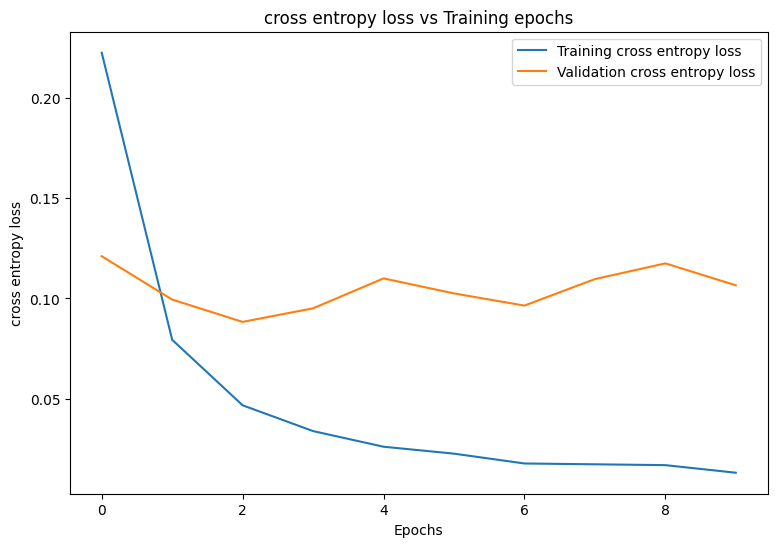

In [22]:
plot_metrics(train_losses, val_losses, "cross entropy loss")

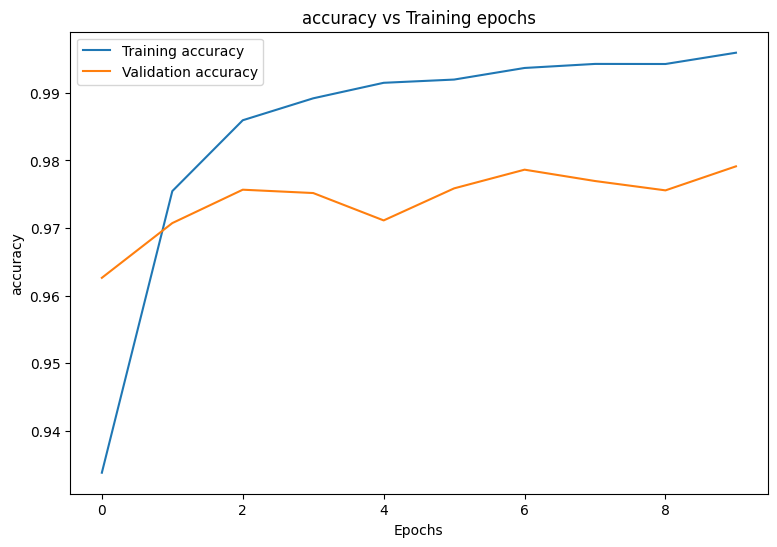

In [23]:
plot_metrics(train_accs, val_accs, "accuracy")

## モデルを保存して読み込む

まず、生データを取り込み、次の演算を実行するエクスポートモジュールを作成します。

- データの前処理
- 確率予測
- クラス予測

In [24]:
class ExportModule(tf.Module):
  def __init__(self, model, preprocess, class_pred):
    # Initialize pre and postprocessing functions
    self.model = model
    self.preprocess = preprocess
    self.class_pred = class_pred

  @tf.function(input_signature=[tf.TensorSpec(shape=[None, None, None, None], dtype=tf.uint8)]) 
  def __call__(self, x):
    # Run the ExportModule for new data points
    x = self.preprocess(x)
    y = self.model(x)
    y = self.class_pred(y)
    return y 

In [25]:
def preprocess_test(x):
  # The export module takes in unprocessed and unlabeled data
  x = tf.reshape(x, shape=[-1, 784])
  x = x/255
  return x

def class_pred_test(y):
  # Generate class predictions from MLP output
  return tf.argmax(tf.nn.softmax(y), axis=1)

次に、このエクスポートモジュールを `tf.saved_model.save` 関数で保存します。 

In [26]:
mlp_model_export = ExportModule(model=mlp_model,
                                preprocess=preprocess_test,
                                class_pred=class_pred_test)

In [27]:
models = tempfile.mkdtemp()
save_path = os.path.join(models, 'mlp_model_export')
tf.saved_model.save(mlp_model_export, save_path)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpqlzp0tgq/mlp_model_export/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpqlzp0tgq/mlp_model_export/assets


保存されたモデルを `tf.saved_model.load` で読み込み、トレーニングに使用されていないテストデータでそのパフォーマンスを調べます。

In [28]:
mlp_loaded = tf.saved_model.load(save_path)

In [29]:
def accuracy_score(y_pred, y):
  # Generic accuracy function
  is_equal = tf.equal(y_pred, y)
  return tf.reduce_mean(tf.cast(is_equal, tf.float32))

x_test, y_test = tfds.load("mnist", split=['test'], batch_size=-1, as_supervised=True)[0]
test_classes = mlp_loaded(x_test)
test_acc = accuracy_score(test_classes, y_test)
print(f"Test Accuracy: {test_acc:.3f}")

Test Accuracy: 0.979


このモデルは、トレーニングデータセット内の手書きの数字をうまく分類し、トレーニングに使用されていないテストデータにも一般化しています。次に、モデルのクラスごとの精度を調べて、各数字のパフォーマンスが良好であることを確認します。 

In [30]:
print("Accuracy breakdown by digit:")
print("---------------------------")
label_accs = {}
for label in range(10):
  label_ind = (y_test == label)
  # extract predictions for specific true label
  pred_label = test_classes[label_ind]
  label_filled = tf.cast(tf.fill(pred_label.shape[0], label), tf.int64)
  # compute class-wise accuracy
  label_accs[accuracy_score(pred_label, label_filled).numpy()] = label
for key in sorted(label_accs):
  print(f"Digit {label_accs[key]}: {key:.3f}")

Accuracy breakdown by digit:
---------------------------
Digit 6: 0.969
Digit 9: 0.972
Digit 7: 0.973
Digit 5: 0.974
Digit 3: 0.977
Digit 4: 0.979
Digit 0: 0.981
Digit 8: 0.982
Digit 2: 0.987
Digit 1: 0.992


いくつかの数字では、他の数字よりもモデルのパフォーマンスが低くなっています。これは、多くのマルチクラス分類問題で非常に一般的です。最後の演習として、モデルの予測とそれに対応する真のラベルの混同行列をプロットして、より多くのクラス レベルの洞察を収集します。 Sklearn と seaborn には、混同行列を生成して視覚化する関数があります。 

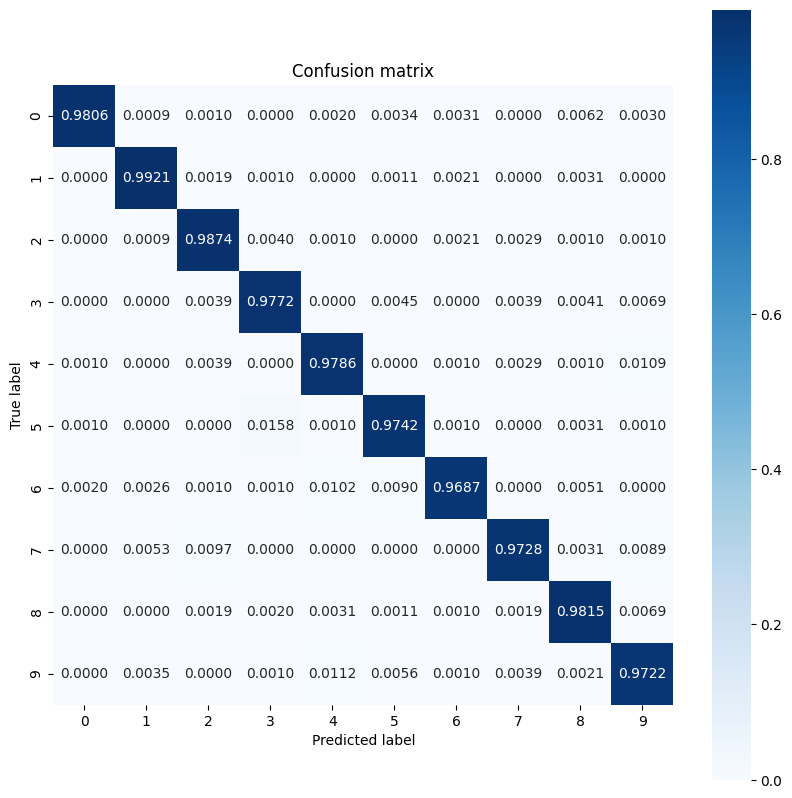

In [31]:
import sklearn.metrics as sk_metrics

def show_confusion_matrix(test_labels, test_classes):
  # Compute confusion matrix and normalize
  plt.figure(figsize=(10,10))
  confusion = sk_metrics.confusion_matrix(test_labels.numpy(), 
                                          test_classes.numpy())
  confusion_normalized = confusion / confusion.sum(axis=1)
  axis_labels = range(10)
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.4f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

show_confusion_matrix(y_test, test_classes)

クラスレベルの洞察は、誤分類の理由を特定し、将来のトレーニングサイクルでモデルのパフォーマンスを向上させるのに役立ちます。

## まとめ

このノートブックでは、[MLP](https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/softmax) を使用してマルチクラス分類の問題を処理するためのいくつかの手法を紹介しました。以下に役立つヒントをいくつか紹介します。

- [TensorFlow Core API](https://www.tensorflow.org/guide/core) を使用して、高度な設定が可能な機械学習ワークフローを構築できます。
- 初期化スキームは、トレーニング時にモデルパラメータが大きくなりすぎたり小さくなりすぎたりするのを防ぐのに役立ちます。
- 過学習は、ニューラルネットワークのもう 1 つの一般的な問題ですが、このチュートリアルでは問題になりませんでした。詳しくは、[過学習と過少学習](overfit_and_underfit.ipynb)のチュートリアルを参照してください。

TensorFlow Core API のその他の使用例については、[チュートリアル](https://www.tensorflow.org/guide/core)を参照してください。データの読み込みと準備についてさらに学習するには、[画像データの読み込み](https://www.tensorflow.org/tutorials/load_data/images)または [CSV データの読み込み](https://www.tensorflow.org/tutorials/load_data/csv)に関するチュートリアルを参照してください。